In [ ]:

import os
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from thop import profile

class MiniImageNetDataset(Dataset):
    def __init__(self, txt_file, img_dir, transform=None, channel_mask='RGB'):
        self.img_dir = img_dir
        self.transform = transform
        self.channel_mask = channel_mask
        self.samples = []
        with open(txt_file, 'r') as f:
            for line in f:
                path, label = line.strip().split()
                self.samples.append((path, int(label)))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(os.path.join(self.img_dir, path)).convert('RGB')
        if self.transform:
            img = self.transform(img)
            channel_indices = {'R': 0, 'G': 1, 'B': 2}
            selected = [channel_indices[c] for c in self.channel_mask]
            img = img[selected, :, :]
        return img, label


class DynamicChannelConv(nn.Module):
    def __init__(self, max_in_channels, out_channels, kernel_size=3, hidden_dim=128):
        super().__init__()
        self.max_in_channels = max_in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size

        self.weight_gen = nn.Sequential(
            nn.Linear(max_in_channels, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_channels * max_in_channels * kernel_size * kernel_size)
        )
        self.bias = nn.Parameter(torch.zeros(out_channels))

    def forward(self, x):
        B, C, H, W = x.size()
        device = x.device
        channel_indicator = torch.zeros((B, self.max_in_channels), device=device)
        channel_indicator[:, :C] = 1.0
        weights = self.weight_gen(channel_indicator)
        weights = weights.view(B, self.out_channels, self.max_in_channels, self.kernel_size, self.kernel_size)

        out = []
        for i in range(B):
            weight_i = weights[i, :, :C, :, :]
            out_i = F.conv2d(x[i:i+1], weight_i, bias=self.bias, padding=self.kernel_size // 2)
            out.append(out_i)
        return torch.cat(out, dim=0)

def accuracy(output, target, topk=(1,)):
    maxk = max(topk)
    _, pred = output.topk(maxk, 1, True, True)
    correct = pred.eq(target.view(-1, 1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:, :k].sum().item()
        res.append(100.0 * correct_k / target.size(0))
    return res

# 設定參數
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])
batch_size = 32
num_classes = 50
image_dir = 'C:/Users/kyt/Desktop/images'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 模型建立（支援 dynamic hidden dim 測試）
def build_dynamic_model(hidden_dim=128, out_channels=64):
    return nn.Sequential(
        DynamicChannelConv(max_in_channels=3, out_channels=out_channels, hidden_dim=hidden_dim),
        nn.ReLU(),
        nn.AdaptiveAvgPool2d(1),
        nn.Flatten(),
        nn.Linear(out_channels, num_classes)
    ).to(device)

# baseline 模型（固定 RGB）
def build_baseline_model():
    return nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.AdaptiveAvgPool2d(1),
        nn.Flatten(),
        nn.Linear(64, num_classes)
    ).to(device)
def evaluate_model(model, data_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            _, pred = out.max(1)
            correct += pred.eq(y).sum().item()
            total += y.size(0)
    return 100. * correct / total

acc_results = {}
flops_results = {}
params_results = {}

# 動態模型 ablation 實驗（hidden_dim, out_channels 組合）
hyper_configs = [(64, 64), (128, 64), (128, 32), (128, 128)]
for hidden_dim, out_ch in hyper_configs:
    print(f"\n 訓練 DynamicConv(hidden_dim={hidden_dim}, out_channels={out_ch})")
    model = build_dynamic_model(hidden_dim=hidden_dim, out_channels=out_ch)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    train_set = MiniImageNetDataset('train.txt', image_dir, transform)
    val_set = MiniImageNetDataset('val.txt', image_dir, transform)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size)

    for epoch in range(3):
        model.train()
        running_loss = 0.0 
        for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()



    print("\n 多通道測試：")
    test_channel_masks = ['RGB', 'RG','RB','GB', 'R', 'G', 'B']
    for mask in test_channel_masks:
        test_set = MiniImageNetDataset('test.txt', image_dir, transform, channel_mask=mask)
        test_loader = DataLoader(test_set, batch_size=batch_size)

        model.eval()
        total_acc = 0
        total = 0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                acc = accuracy(out, y)[0]
                total_acc += acc * y.size(0)
                total += y.size(0)
        acc_results[f"D{hidden_dim}_{out_ch}_{mask}"] = total_acc / total
        dummy_input = torch.randn(1, 3, 32, 32).to(device)
        macs, params = profile(model, inputs=(dummy_input,), verbose=False)
        flops_results[f"D{hidden_dim}_{out_ch}_{mask}"] = macs / 1e6
        params_results[f"D{hidden_dim}_{out_ch}_{mask}"] = params / 1e3
        print(f" FLOPs: {macs/1e6:.2f}M, Params: {params/1e3:.2f}K")
        val_acc = evaluate_model(model, val_loader)
        print(f"[{mask}] Accuracy: {total_acc / total:.2f}%")



print("\n Baseline CNN 模型測試")
model = build_baseline_model()
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


for epoch in range(3):
    model.train()
    for x, y in tqdm(train_loader, desc=f"Baseline Epoch {epoch+1}"):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()


test_set = MiniImageNetDataset('test.txt', image_dir, transform, channel_mask='RGB')
test_loader = DataLoader(test_set, batch_size=batch_size)
model.eval()
total_acc = 0
total = 0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        acc = accuracy(out, y)[0]
        total_acc += acc * y.size(0)
        total += y.size(0)
print(f"[Baseline RGB] Accuracy: {total_acc / total:.2f}%")
from thop import profile
dummy_input = torch.randn(1, 3, 32, 32).to(device)
macs, params = profile(model, inputs=(dummy_input,), verbose=False)
print(f"[Baseline] FLOPs: {macs/1e6:.2f}M, Params: {params/1e3:.2f}K")
acc_results['Baseline_RGB'] = total_acc / total
flops_results['Baseline_RGB'] = macs / 1e6
params_results['Baseline_RGB'] = params / 1e3



 訓練 DynamicConv(hidden_dim=64, out_channels=64)


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 1979/1979 [02:05<00:00, 15.80it/s]



 多通道測試：
 FLOPs: 0.18M, Params: 115.83K
[RGB] Accuracy: 9.56%
 FLOPs: 0.18M, Params: 115.83K
[RG] Accuracy: 2.00%
 FLOPs: 0.18M, Params: 115.83K
[RB] Accuracy: 2.00%
 FLOPs: 0.18M, Params: 115.83K
[GB] Accuracy: 2.00%
 FLOPs: 0.18M, Params: 115.83K
[R] Accuracy: 2.00%
 FLOPs: 0.18M, Params: 115.83K
[G] Accuracy: 2.00%
 FLOPs: 0.18M, Params: 115.83K
[B] Accuracy: 1.78%

 訓練 DynamicConv(hidden_dim=128, out_channels=64)


Epoch 1:  29%|████████████████████                                                  | 566/1979 [00:37<01:30, 15.69it/s]

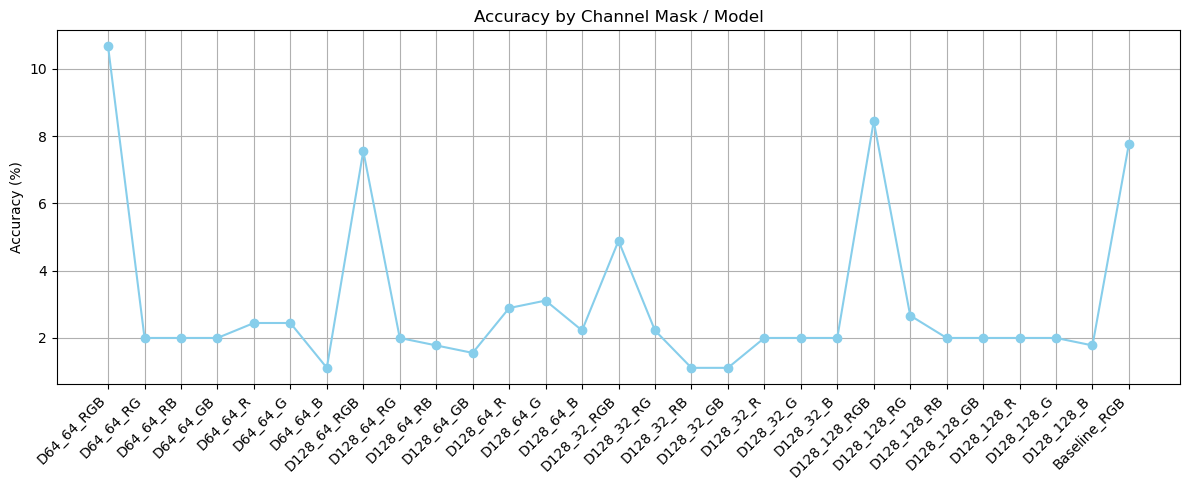

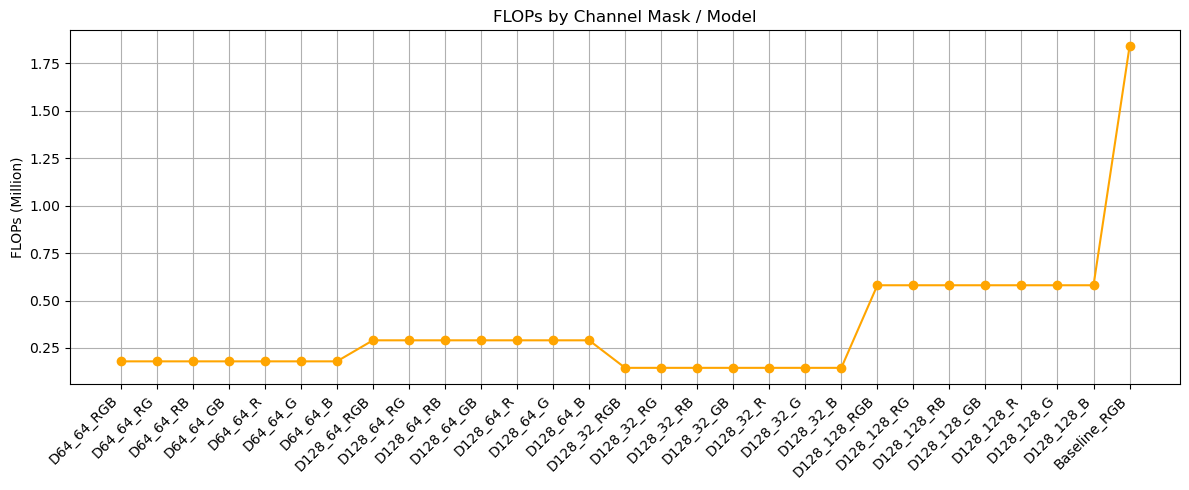

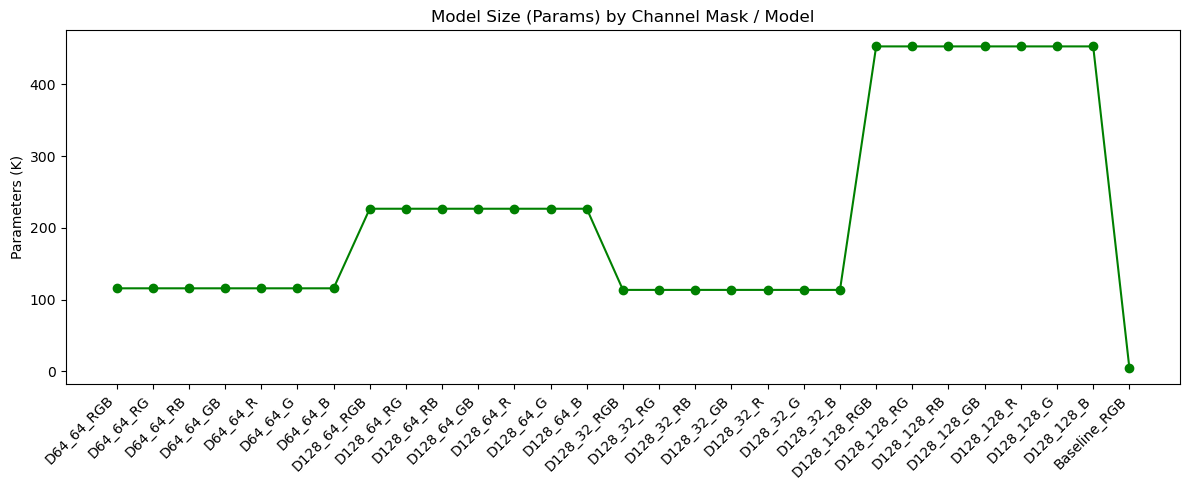

In [6]:
import matplotlib.pyplot as plt

# Accuracy 折線圖
plt.figure(figsize=(12, 5))
plt.plot(list(acc_results.keys()), list(acc_results.values()), marker='o', linestyle='-', color='skyblue', label="Accuracy")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Accuracy (%)")
plt.title("Accuracy by Channel Mask / Model")
plt.grid(True)
plt.tight_layout()
plt.show()

# FLOPs 折線圖
plt.figure(figsize=(12, 5))
plt.plot(list(flops_results.keys()), list(flops_results.values()), marker='o', linestyle='-', color='orange', label="FLOPs")
plt.xticks(rotation=45, ha='right')
plt.ylabel("FLOPs (Million)")
plt.title("FLOPs by Channel Mask / Model")
plt.grid(True)
plt.tight_layout()
plt.show()

# Params 折線圖
plt.figure(figsize=(12, 5))
plt.plot(list(params_results.keys()), list(params_results.values()), marker='o', linestyle='-', color='green', label="Params")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Parameters (K)")
plt.title("Model Size (Params) by Channel Mask / Model")
plt.grid(False)
plt.tight_layout()
plt.show()
